In [132]:
from differences import ATTgt
from matplotlib import pyplot as plt
from analysis_utilities import aggregate_by_time_and_plot, aggregate_by_event_time_and_plot, \
    select_controls, test_balance, add_missing_indicators, prepare_df, generate_variable_names

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/crime_analysis.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/crime_60m/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/crime_60m/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

analysis='any_crime_60m'

In [133]:
import numpy as np

value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = generate_variable_names(analysis=analysis)

# Uncomment below line for "any crime" analysis
# df[value_vars_crime] = np.where(df[value_vars_crime] > 0, 1, 0)

In [122]:
covariates_exploration_df = select_controls(df=df, analysis=analysis, output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                       Any Crime Incidents Within 60m, Dec. 2022   
                                                 \emph{Independent Variable}                                                       
Panel A: Pre-treatment Outcomes                  twenty_seventeen_any_crime_60m                                    6.750836e-219   
                                                 pre_treatment_change_in_any_crime_60m                              5.113942e-14   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                 9.392266e-01   
                                                 job_density_2013                                                   4.473447e-06   
                                                 med_hhinc2016                                                      9.255893e-02   
                                                 poor_share2010                                                     9.565347e-01   
                                                 popdensity2010                                                     1.555235e-02   
                                                 rent_twobed2015                                                    7.242181e-01   
                                                 share_white2010                                                    8.807482e-01   
                                                 traveltime15_2010                                                  1.025469e-02   
Panel C: Case Initiation                         for_cause                                                          2.203751e-01   
                                                 no_cause                                                           6.997831e-01   
                                                 non_payment                                                        8.494799e-02   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                           6.395843e-02   
                                                 hasAttyP                                                           2.779594e-03   
                                                 isEntityD                                                          8.393889e-01   
                                                 isEntityP                                                          7.179508e-03   

                                                                                                          
                                                                                       Plaintiff Victory  
                                                 \emph{Independent Variable}                              
Panel A: Pre-treatment Outcomes                  twenty_seventeen_any_crime_60m             4.919557e-01  
                                                 pre_treatment_change_in_any_crime_60m      7.868511e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                         2.403331e-01  
                                                 job_density_2013                           1.626836e-01  
                                                 med_hhinc2016                              1.910501e-01  
                                                 poor_share2010                             1.428679e-01  
                                                 popdensity2010                             5.946111e-02  
                                                 rent_twobed2015                            5.003043e-01  
                                                 share_white2010                            9.829904e-02  
                                                 traveltime15_2010                          2.271578e-01  
Panel C: Case Initiation                         for_cause                    

In [123]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                                Cases Won by Plaintiff   
Panel A twenty_seventeen_any_crime_60m                        0.472119   
        pre_treatment_change_in_any_crime_60m                -0.027309   
Panel B Jobs per square mile (2010)                       16069.137185   
        Population density (2010)                         23086.043553   
        Share with commute $<$15 minutes (2010)               0.162315   
Panel D Plaintiff has an attorney                             0.879853   
        Plaintiff is an entity                                0.808499   

                                                Difference in Cases Won by Defendant  \
                                                                          Unweighted   
Panel A twenty_seventeen_any_crime_60m                                      0.033597   
        pre_treatment_change_in_any_crime_60m                               0.010778   
Panel B Jobs per square mile (2010)                                      3197.929971   
        Population density (2010)                                        1373.148087   
        Share with commute $<$15 minutes (2010)                             0.005986   
Panel D Plaintiff has an attorney                                           0.071601   
        Plaintiff is an entity                                              0.099762   

                                                                       \
                                                 \emph{p}    Weighted   
Panel A twenty_seventeen_any_crime_60m           0.491956   -0.002862   
        pre_treatment_change_in_any_crime_60m    0.786851    0.006365   
Panel B Jobs per square mile (2010)              0.162684  903.790439   
        Population density (2010)                0.059461 -271.377925   
        Share with commute $<$15 minutes (2010)  0.227158   -0.003696   
Panel D Plaintiff has an attorney                0.000102   -0.000953   
        Plaintiff is an entity                   0.000006    0.015678   

                                                           
                                                 \emph{p}  
Panel A twenty_seventeen_any_crime_60m           0.953051  
        pre_treatment_change_in_any_crime_60m    0.873793  
Panel B Jobs per square mile (2010)              0.688746  
        Population density (2010)                0.677928  
        Share with commute $<$15 minutes (2010)  0.420487  
Panel D Plaintiff has an attorney                0.933192  
        Plaintiff is an entity                   0.272676

In [124]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_month_variable = treatment_date_variable.replace('date', 'month')

# Generate indicators for missing data.
add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = prepare_df(df, analysis, treatment_date_variable, pre_treatment_covariates, value_vars_crime, month_to_int_dictionary)

In [125]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 2184/2184 [00:15<00:00, 142.50it/s]


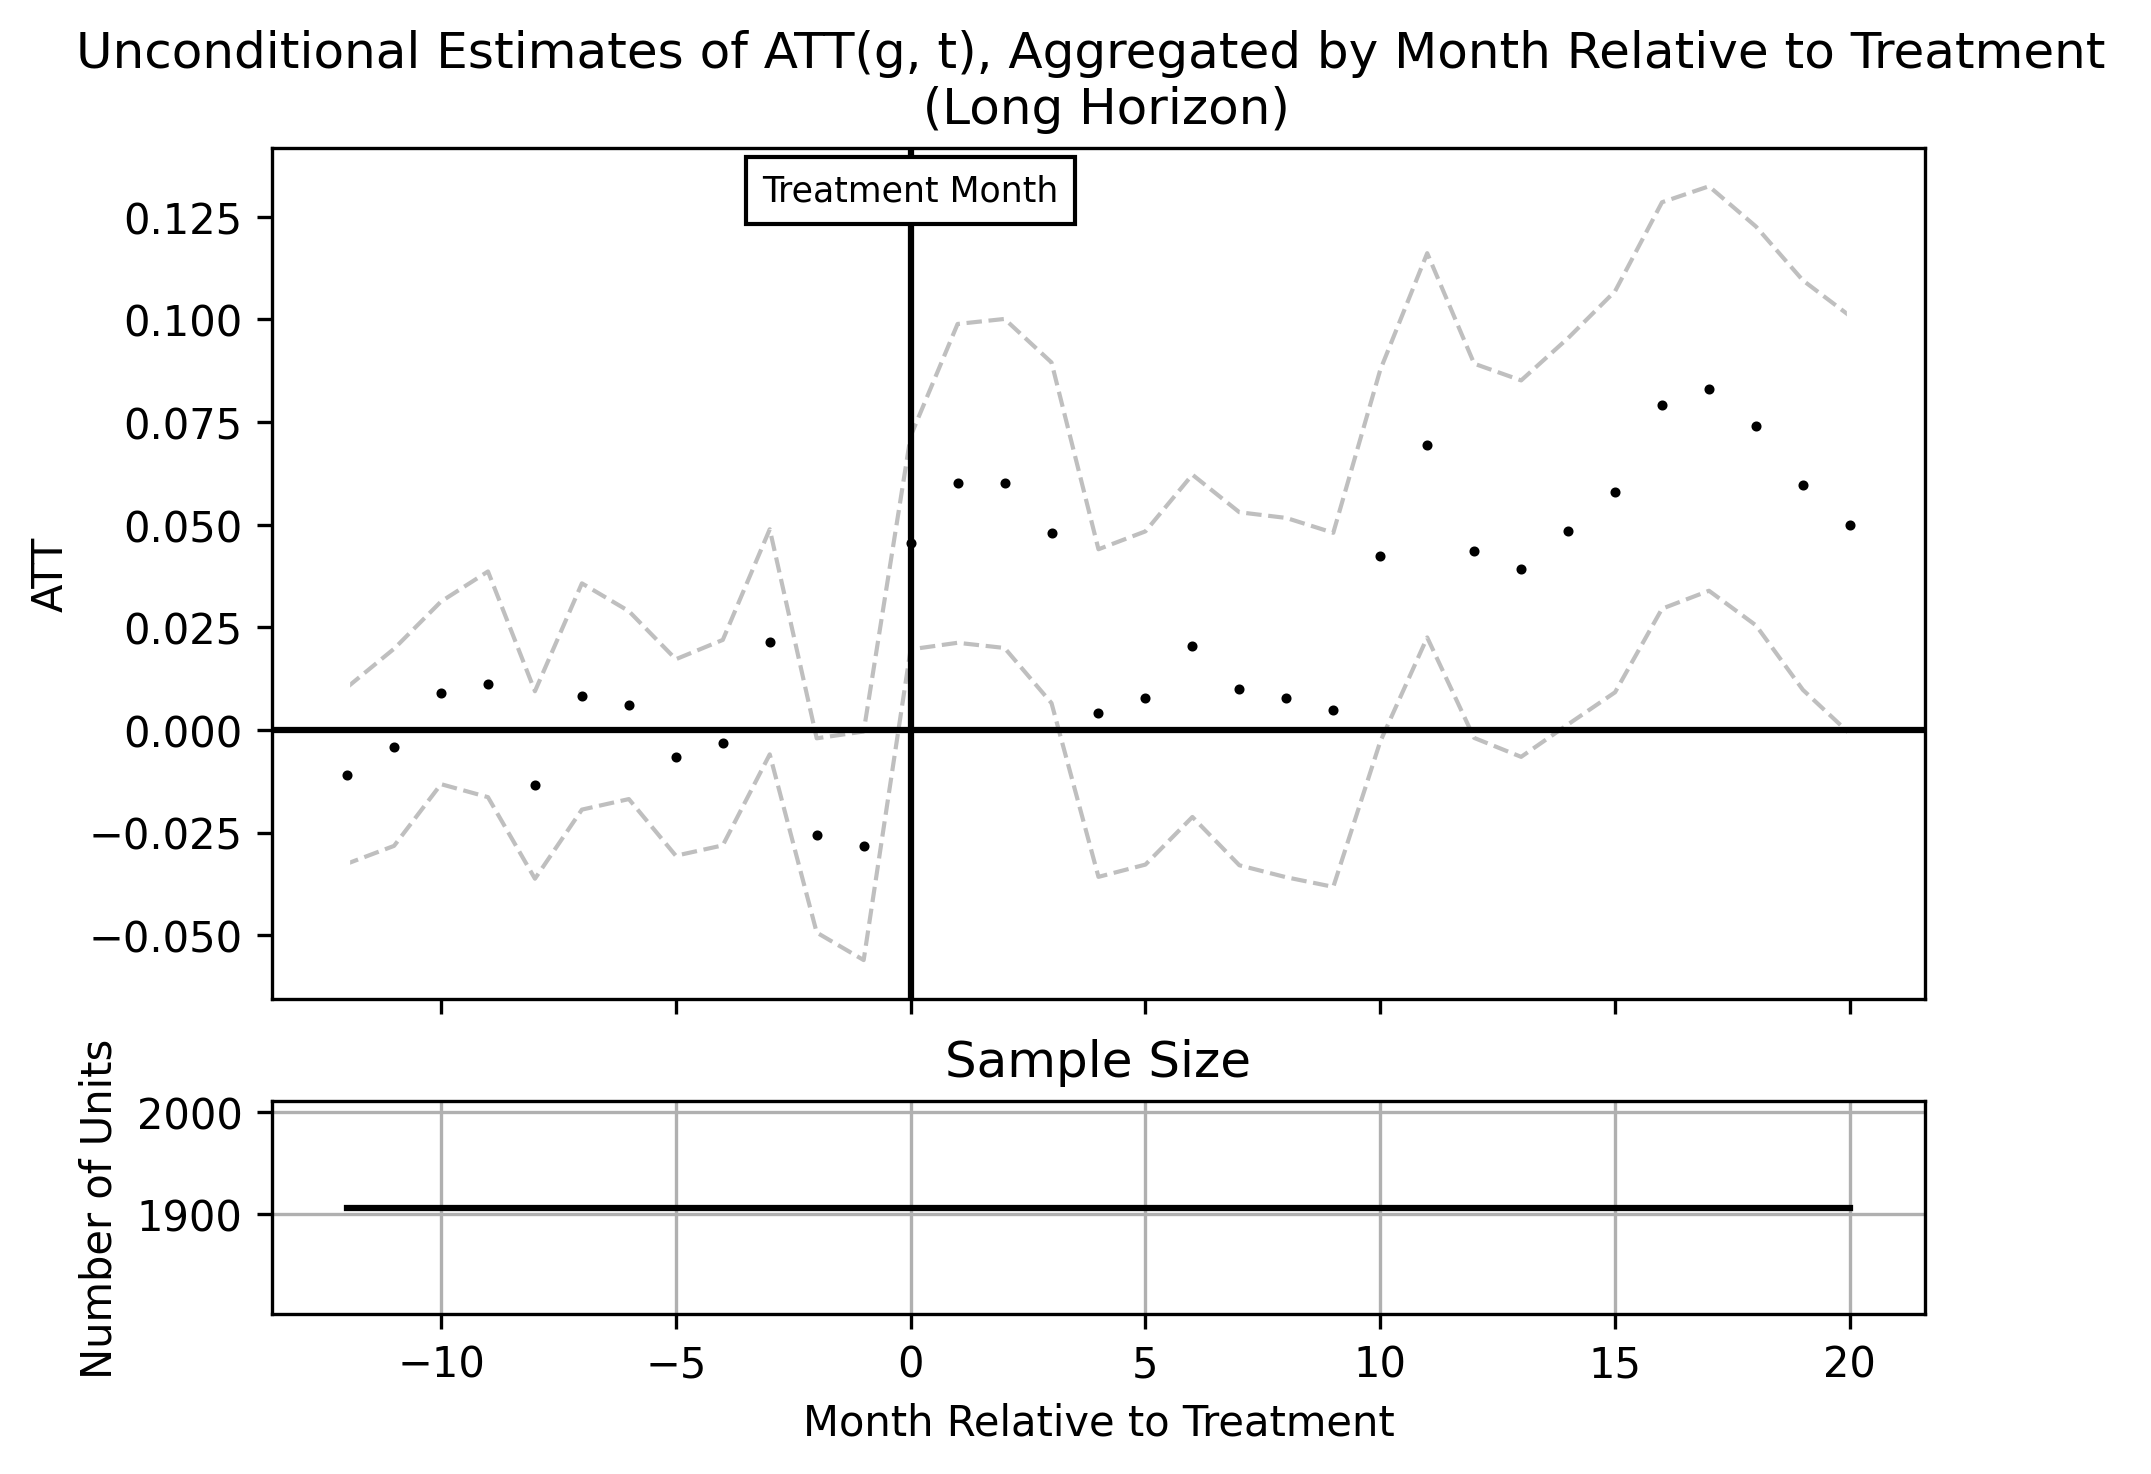

In [126]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=20,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

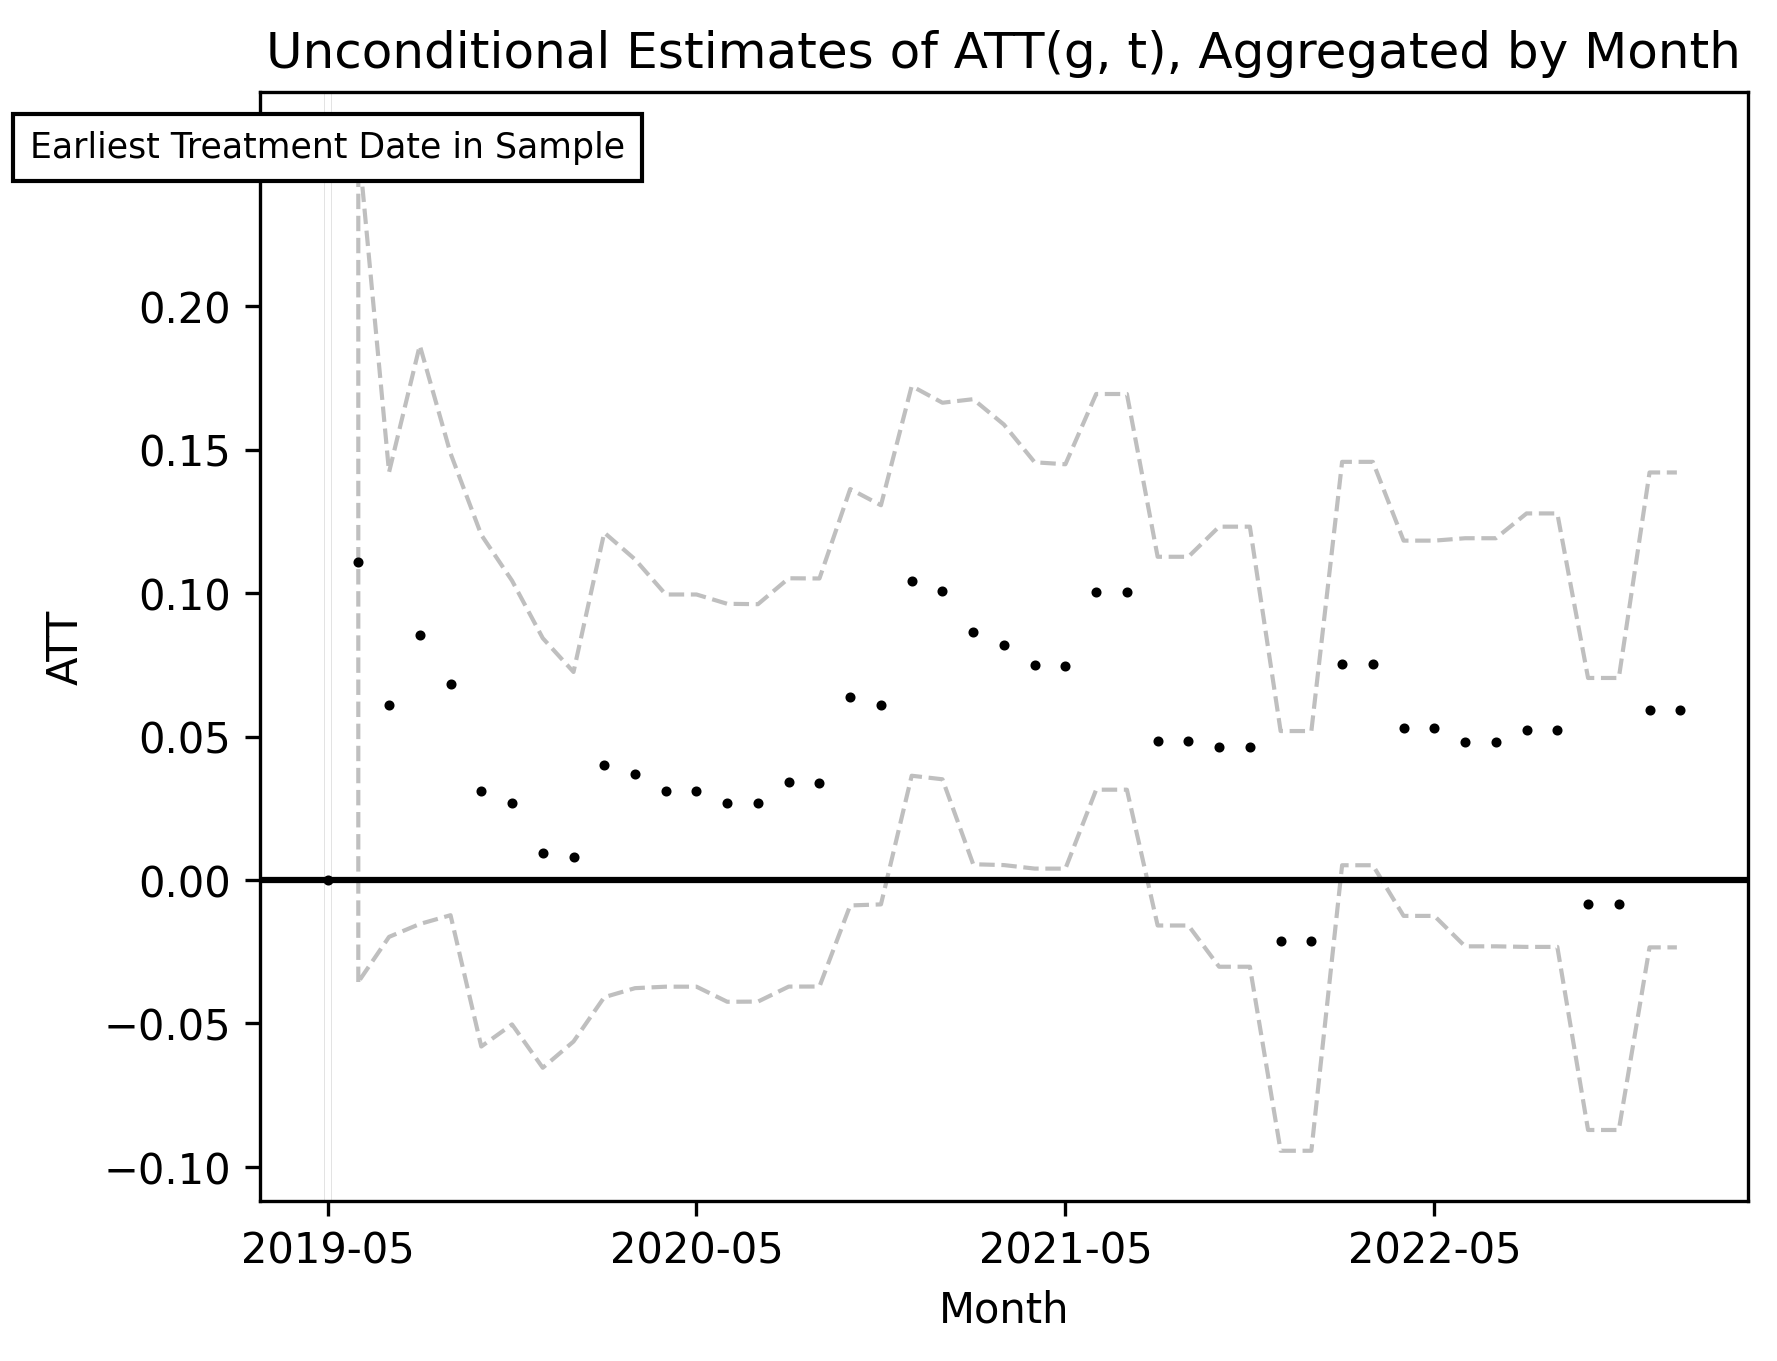

In [127]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [128]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]   54%|██████████▊         | 1180/2184 [00:11<00:07, 140.85it/s]/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow enco

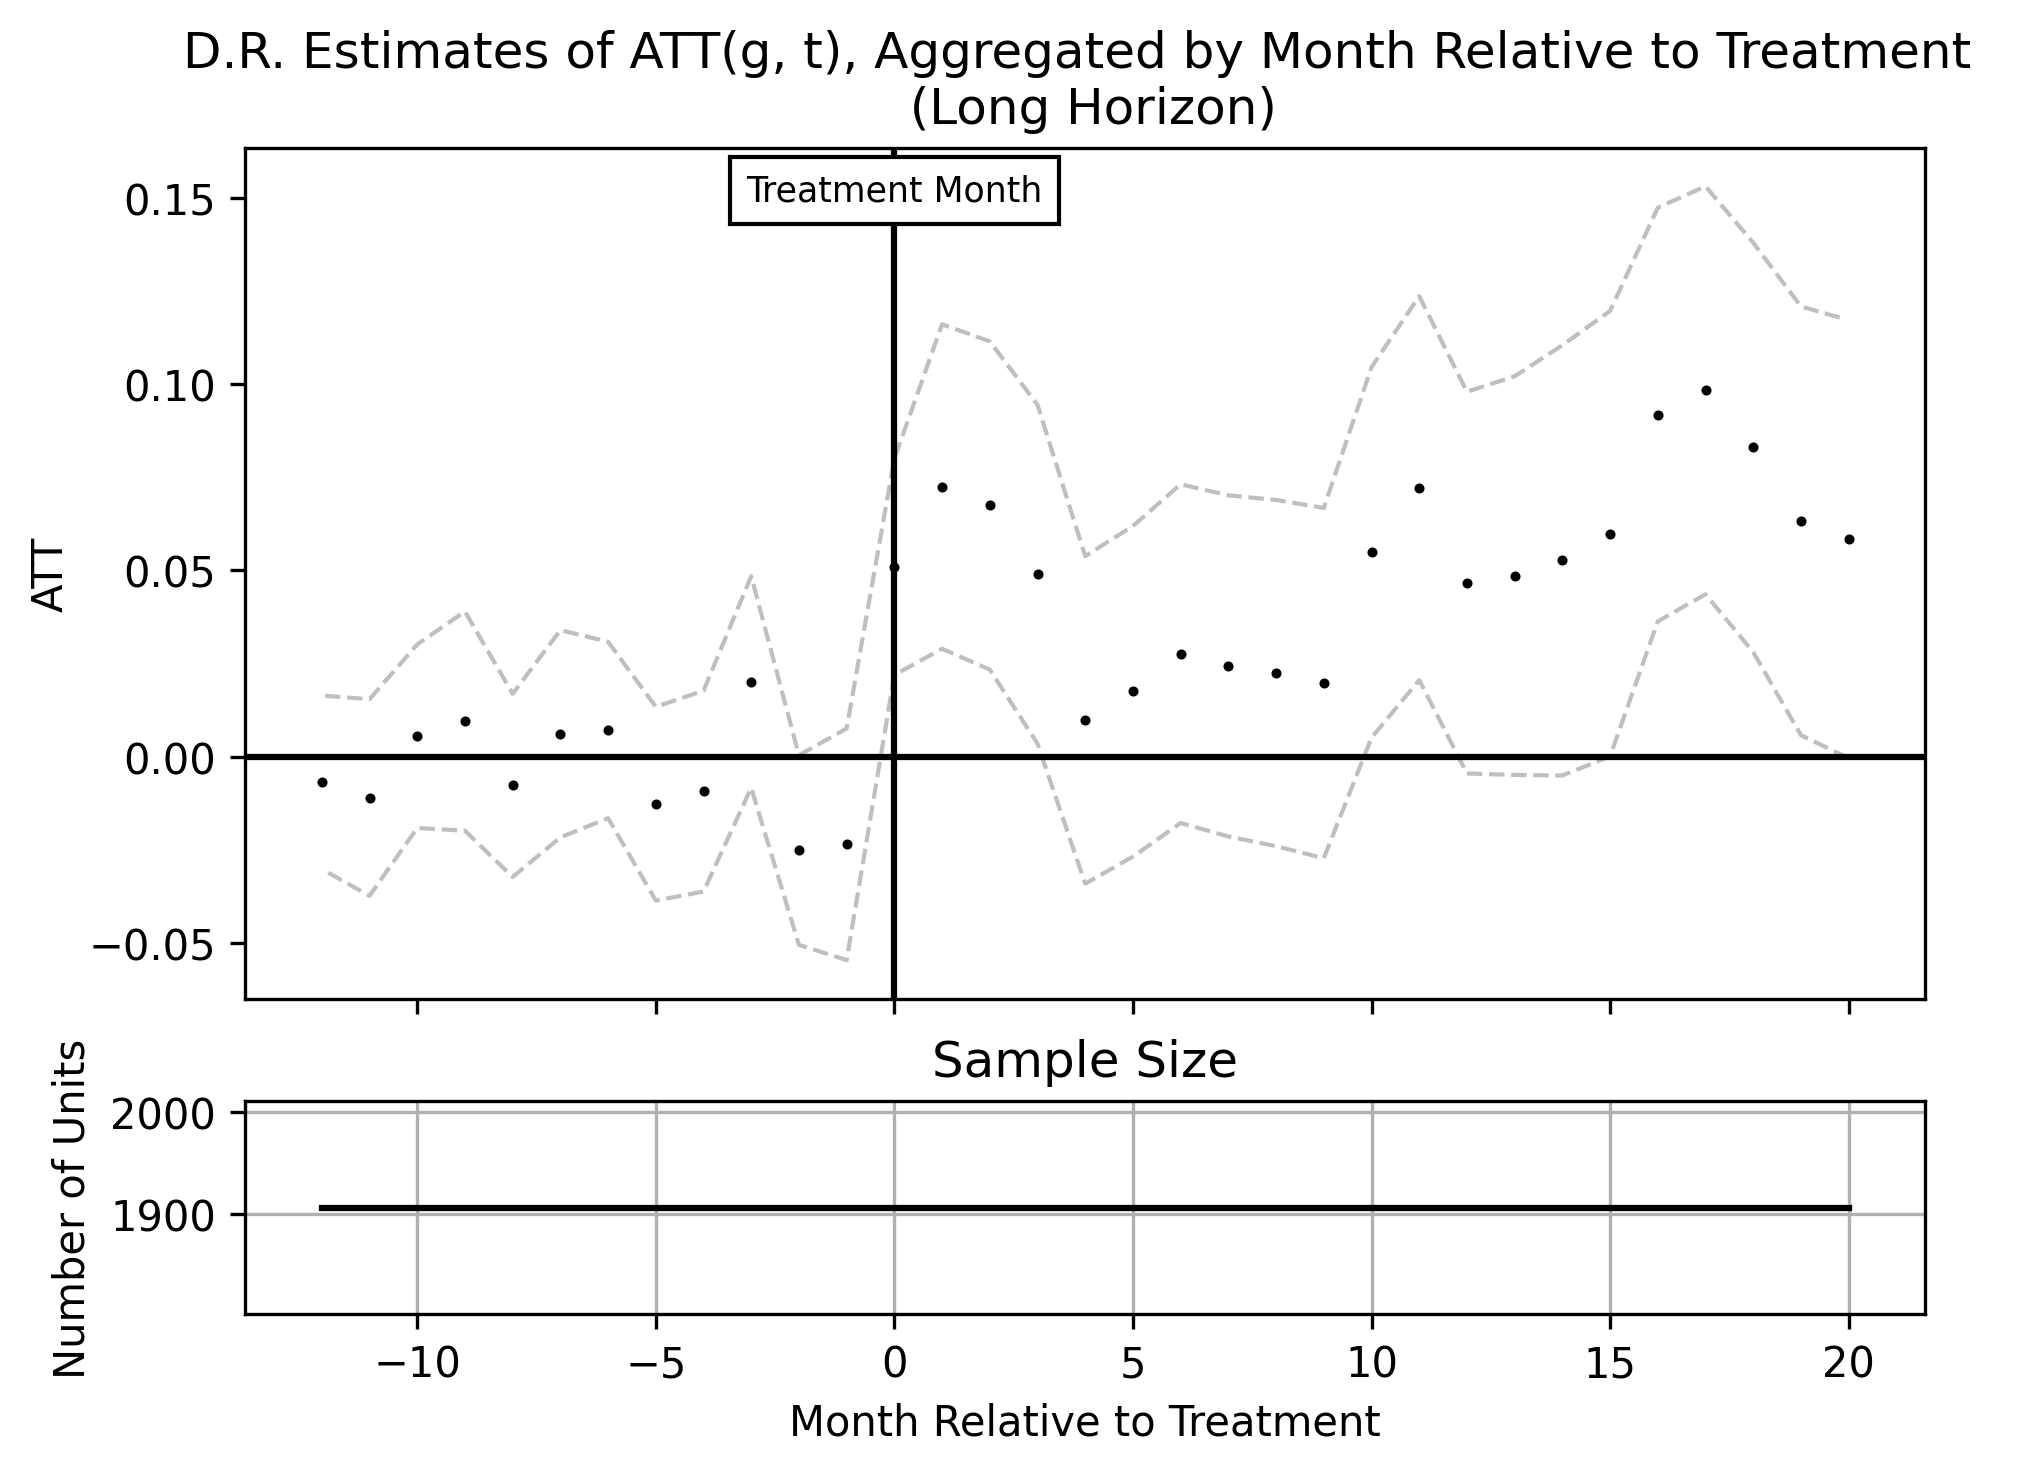

In [129]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=20,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

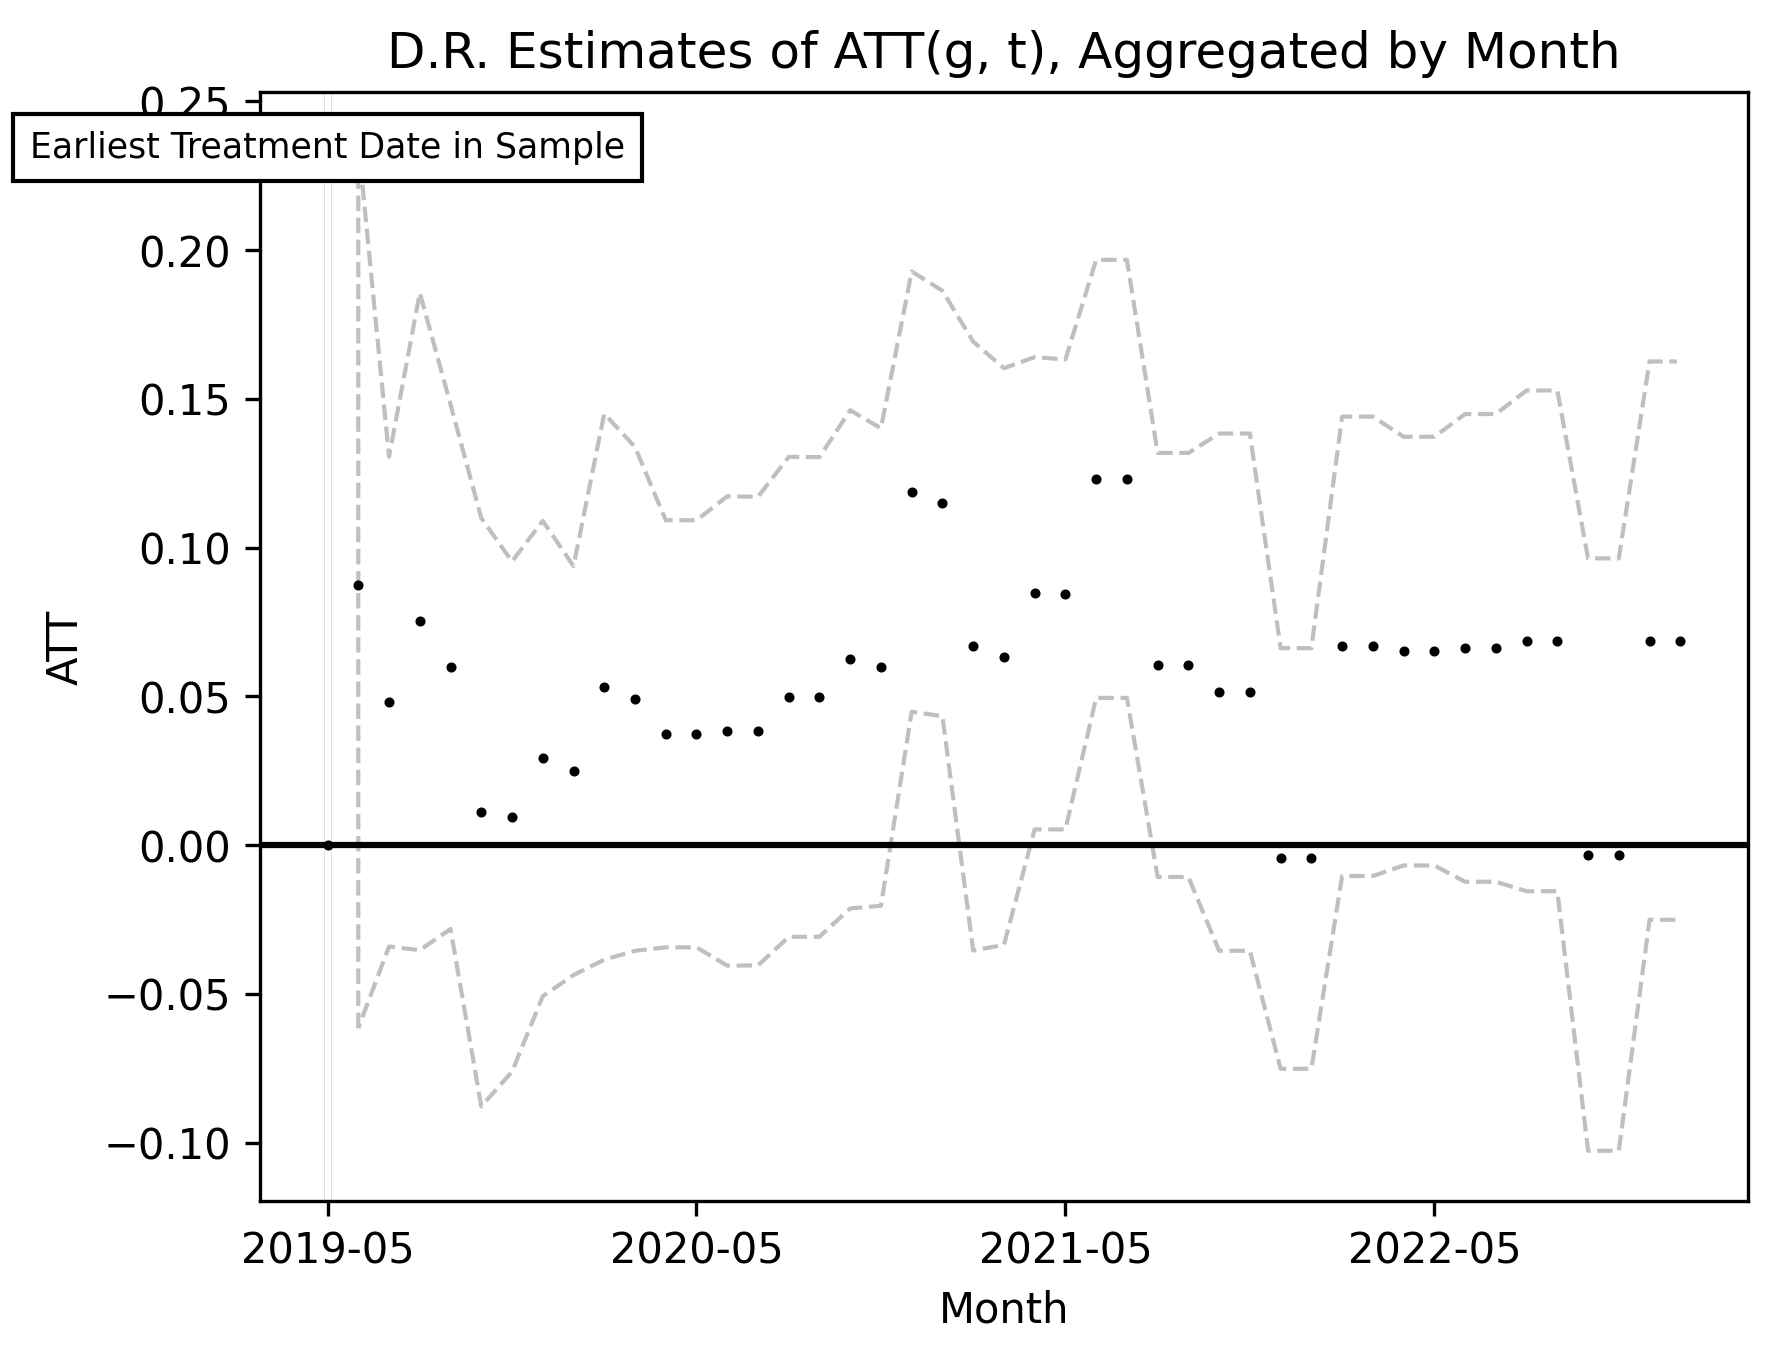

In [130]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")